# Identifying a 2D SSM for an oscillator chain

_(Based on the ```Matlab``` live script https://github.com/haller-group/SSMLearn/tree/main/examples/oscillatorchain)_

This is an example of how to reconstruct a slow 2D SSM of a mechanical system using synthetic measurements of the full state space. In this example, we consider a damped oscillator chain with an additional nonlinear spring attached to the leftmost mass. The measurements for this example are transients occurring from exact initial conditions on the slow 2D SSM.

## Setup 

The $N$-degree of freedom dynamical system is defined as

$$
\mathbf{M\ddot{q}} + \mathbf{C\dot{q}} + \mathbf{Kq} + \mathbf{f}(\mathbf{q},\mathbf{\dot{q}}) 
= \mathbf{0}
$$

where $\mathbf{f}$ represents the nonlinearities and $\mathbf{M}$, $\mathbf{K}$ ,  and $\mathbf{C}$ are the  mass, stiffness, and damping matrices, respectively.
We rewrite the system in first-order form as

$$
\mathbf{\dot{y}} = \mathbf{A}\mathbf{y} + \mathbf{G}(\mathbf{y}) = \mathbf{F}(\mathbf{y})
$$

with 

$$
\mathbf{y}=\left[\begin{array}{c}\mathbf{q}\\\dot{\mathbf{q}}\end{array}\right],\quad\mathbf{A}=\left[\begin{array}{cc}\mathbf{0}  & \mathbf{I}\\-\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{array}\right],\quad\mathbf{G}(\mathbf{y})=\left[\begin{array}{c}  \mathbf{0} \\ -\mathbf{M}^{-1}\mathbf{f}(\mathbf{y})\end{array}\right].$$

In [1]:
n = 5 # number of masses 
mass = 1 
mass1 = 1.5
stiffness = 1
dampingM = 0.002
dampingK = 0.005

In [2]:
from ssmlearnpy import SSMLearn


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
vMass = np.ones(n)


In [5]:
M = mass*np.diag(vMass)
M[0,0] = mass1


In [6]:
K = stiffness*(2*np.eye(n) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1));


In [7]:
K[-1,-1] = 1

In [8]:
C = dampingM*M + dampingK*K

### We consider quadratic and cubic nonlinearities: 

$$
\mathbf{f}_1 = 0.33\dot{q}_1^2 + 3q_1^3 + 0.7 q_1^2 \dot{q_1} + 0.5\dot{q}_1^3
$$

To convert to first order form, define the matrix $\mathbf{A}$

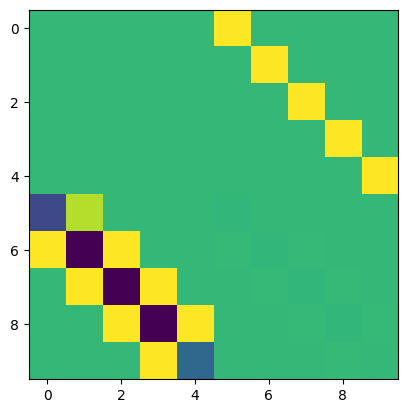

In [9]:

A = np.vstack((np.hstack((np.zeros((n,n)), np.eye(n))), 
              np.hstack((-np.linalg.inv(M)@K, -np.linalg.inv(M)@C))))
plt.imshow(A)

In [10]:
def vectorfield(t,x):
    Linpart = A@x 
    nl = np.array([0.33 * x[5]**2 + 3*x[0]**3 + 0.7 *x[0]**2 * x[5]+ 0.5*x[5]**3])
    return Linpart - nl

In [11]:
from scipy.integrate import solve_ivp

### We import initial conditions from Matlab, generated by SSMTool

In [12]:
from scipy.io import loadmat

In [13]:
dat = loadmat('ics.mat')

In [14]:
ic1 = dat['IC'][:,0]
ic2 = dat['IC'][:,1]

In [15]:
slowTime = 22.2382

In [16]:
nPeriods = 140 
nDataPerPeriod = 50
endTime = nPeriods * slowTime;
nSamp = nDataPerPeriod * nPeriods + 1
dt = endTime/(nSamp-1)


In [17]:
sol1 = solve_ivp(vectorfield, [0, endTime], ic1, t_eval = np.linspace(0, endTime, nSamp), method = 'DOP853')
sol2 = solve_ivp(vectorfield, [0, endTime], ic2, t_eval = np.linspace(0, endTime, nSamp), method = 'DOP853')

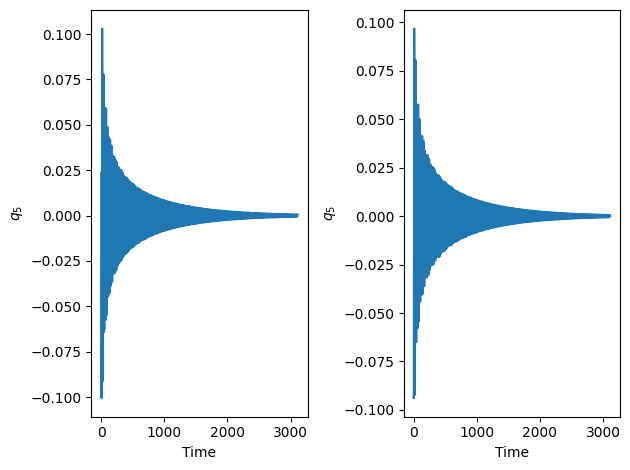

In [18]:
f = plt.figure()
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(sol1.t, sol1.y[6,:], '-')
ax2.plot(sol2.t, sol2.y[6,:], '-')
ax.set_xlabel('Time')
ax.set_ylabel('$q_5$')
ax2.set_xlabel('Time')
ax2.set_ylabel('$q_5$')
f.tight_layout()



In [19]:
ssm = SSMLearn(
    t = [sol1.t, sol2.t], 
    x = [sol1.y, sol2.y], 
    derive_embdedding=False,
    ssm_dim=2, 
    dynamics_type = 'flow',
)

In [20]:
ssm.get_parametrization(poly_degree = 5)

INFO   2023-04-17 03:44:28 ridge Transforming data
INFO   2023-04-17 03:44:28 ridge Skipping CV on ridge regression
INFO   2023-04-17 03:44:28 ridge Fitting regression model


In [21]:
from ssmlearnpy.utils.plots import Plot

plotter = Plot(
    label_observables = 'x',
    label_reduced_coordinates = 'eta'
)

Visualize the predictions over a grid: 

In [22]:
xx = np.linspace(-1.2, 1, 100)
yy = np.linspace(-0.3, .3, 100)
X, Y = np.meshgrid(xx, yy)
points = np.vstack((X.ravel(), Y.ravel()))

In [23]:
Z = ssm.decoder.predict(points)

Extract the $q_1$, $\dot{q}_1$, $\dot{q}_5$ components:

In [24]:
Z1 = Z[0,:]
Z2 = Z[6,:]
Z3 = Z[-1,:]


In [25]:
import matplotlib.tri as mtri


In [26]:
tri = mtri.Triangulation(points[0,:], points[1,:])


Text(0.5, 0, '$\\dot{q}_5$')

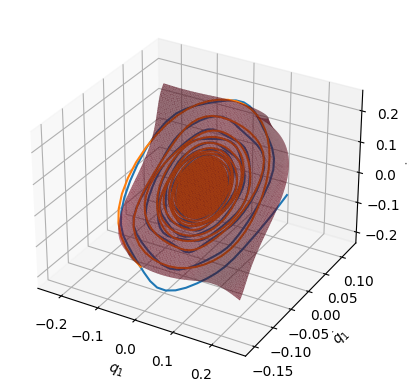

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(Z1, Z2, Z3, triangles=tri.triangles, color = 'crimson', alpha = 0.7, antialiased = True)
# add the trajectories
ax.plot(sol1.y[0, :], sol1.y[6, :], sol1.y[-1, :], '-')
ax.plot(sol2.y[0, :], sol2.y[6, :], sol2.y[-1, :], '-')
ax.set_xlabel('$q_1$')
ax.set_ylabel('$\dot{q}_1$')
ax.set_zlabel('$\dot{q}_5$')


## Fit a reduced order model based on the reduced coordinates

The coordinates are obtained as a projection to a subspace
$$
\begin{pmatrix}\eta_1 \\ \eta_2 \end{pmatrix} = V_e^T \begin{pmatrix}q_1 \\ q_2 \\ \vdots \\ q_5 \\ \vdots \\ \dot{q}_5 \end{pmatrix}
$$

Text(0, 0.5, '$\\eta_2$')

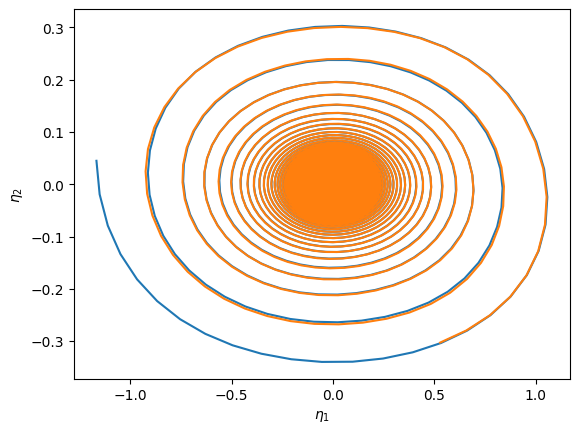

In [28]:
for e in ssm.emb_data['reduced_coordinates']:
    plt.plot(e[0,:], e[1,:], '-')
plt.xlabel('$\eta_1$')
plt.ylabel('$\eta_2$')

Using the plotly backend: 

In [29]:
fig = plotter.make_plot(ssm, data_name = 'reduced_coordinates', idx_coordinates=[1, 2])
fig.show()

First we fit a model without any normalization: 

In [30]:
ssm.get_reduced_dynamics(poly_degree = 5)

INFO   2023-04-17 03:44:39 ridge Transforming data
INFO   2023-04-17 03:44:39 ridge Skipping CV on ridge regression
INFO   2023-04-17 03:44:39 ridge Fitting regression model


### To generate test trajectories, we add random perturbations to one of the training trajectories

In [31]:
np.random.seed(4) # deterministic outcome
testTrajs = []
testTrajs_t = []
for i in range(5):
    ic = ic1 + (np.random.rand(2*n)-1)*2*1e-2 # size 10 vector
    sol_test = solve_ivp(vectorfield, [0, endTime], ic, t_eval = np.linspace(0, endTime, nSamp), method = 'DOP853')
    testTrajs.append(sol_test.y)
    testTrajs_t.append(sol_test.t)
    

Text(0.5, 0, '$\\dot{q}_5$')

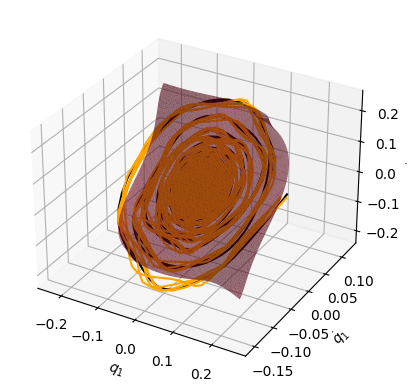

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(Z1, Z2, Z3, triangles=tri.triangles, color = 'crimson', alpha = 0.7, antialiased = True)
# add the trajectories
ax.plot(sol1.y[0, :], sol1.y[6, :], sol1.y[-1, :], '-', c='black')
ax.plot(sol2.y[0, :], sol2.y[6, :], sol2.y[-1, :], '-', c='black')
for t in testTrajs:
    ax.plot(t[0, :], t[6, :], t[-1, :], '-', c='orange')

ax.set_xlabel('$q_1$')
ax.set_ylabel('$\dot{q}_1$')
ax.set_zlabel('$\dot{q}_5$')


In [36]:
predictions = ssm.predict(t = testTrajs_t, x = testTrajs)

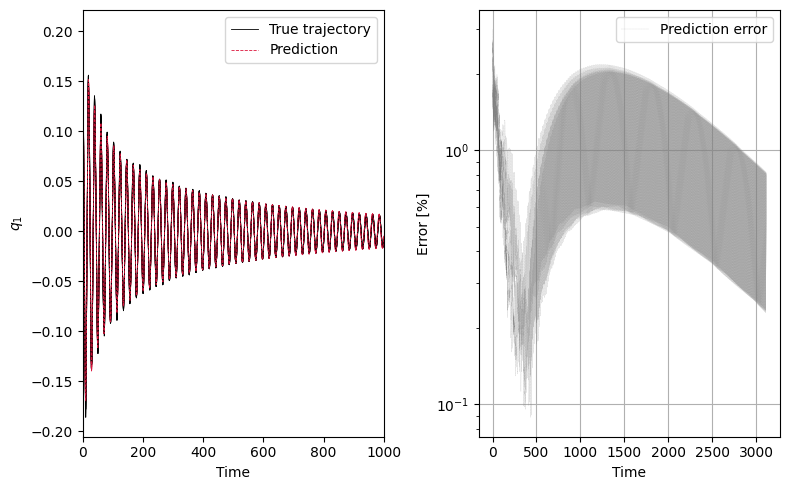

In [72]:
f = plt.figure(figsize = (8,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
flag_label = True
for i, t in enumerate(testTrajs):
    if flag_label:
        ax.plot(testTrajs_t[i], t[0,:], '-', c='black',  linewidth = 0.6,label = 'True trajectory')
        ax.plot(predictions['time'][i], predictions['observables'][i][0,:], '--',  linewidth = 0.6,c='Crimson', label = 'Prediction')
        ax2.semilogy(testTrajs_t[i], predictions['errors'][i]*100, '--',linewidth =0.1, c='grey', label = 'Prediction error')
        
    else:
        ax.plot(testTrajs_t[i], t[0,:], '-', c='black' , linewidth = 0.6,)
        ax.plot(predictions['time'][i], predictions['observables'][i][0,:], '--',  linewidth = 0.6, c='Crimson')
        ax2.semilogy(testTrajs_t[i], predictions['errors'][i]*100, '--', linewidth = 0.1, c='grey')
    flag_label = False
        
ax.set_xlim(0, 1000)
ax.legend()
ax2.legend()
ax.set_xlabel('Time')

ax2.set_xlabel('Time')
ax.set_ylabel('$q_1$')
ax2.set_ylabel('Error [%]')
ax2.grid()
f.tight_layout()